In [15]:
using Pkg, SymPy
using BenchmarkTools, LinearAlgebra, LazyArrays, BandedMatrices, BlockArrays

Pkg.status()

      Status `~/.julia/environments/v1.7/Project.toml`
  [aae01518] BandedMatrices v0.17.0
  [6e4b80f9] BenchmarkTools v1.3.1
  [8e7c35d0] BlockArrays v0.16.18
  [ce91de38] ColorBitstring v0.1.1
  [7073ff75] IJulia v1.23.3
  [5078a376] LazyArrays v0.22.10
  [a3b82374] MatrixFactorizations v0.9.1
  [91a5bcdd] Plots v1.29.0
  [438e738f] PyCall v1.93.1
  [295af30f] Revise v3.3.3
  [f8ebbe35] SemiseparableMatrices v0.3.3
  [3cc68bcd] SetRounding v0.2.1
  [24249f21] SymPy v1.1.6
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [8dfed614] Test


In [16]:
# l,u = 2,1          # block bandwidths
# N = M = 4          # number of row/column blocks
# cols = rows = 1:N  # block sizes

# BlockBandedMatrix(Zeros(sum(rows),sum(cols)), rows,cols, (l,u)) # creates a block-banded matrix of zeros
# BlockBandedMatrix(Ones(sum(rows),sum(cols)), rows,cols, (l,u)) # creates a block-banded matrix with ones in the non-zero entries
# BlockBandedMatrix(I, rows,cols, (l,u))                          # creates a block-banded  identity matrix

In [17]:
function BackwardSubstitutionV(U, b)
    T = eltype(U)
    n = size(U)[2]
    x = zeros(T, n)
    x[n] = b[n] / U[n, n]
    for i in n-1 : -1 : 1
        sum_ = zero(T)
        for j in i+1 : n
            sum_ += U[i, j] * x[j]
        end
        x[i] = (b[i] - sum_) / U[i, i]
    end
    x
end

function BandedBackwardSubstitutionV(U, b, bw)
    T = eltype(U)
    n = size(U)[2]
    x = zeros(T, n)
    x[n] = b[n] / U[n, n]
    for i in n-1 : -1 : 1
        sum_ = zero(T)
        for j in i+1 : min(n, i+bw)
            sum_ += U[i, j] * x[j]
        end
        x[i] = (b[i] - sum_) / U[i, i]
    end
    x
end

function BandedBackwardSubstitutionM(U, B, bw)
    T = eltype(U)
    n = size(U)[2]
    l = size(B)[2]
    X = zeros(T, n, l)
    for j in l : -1 : 1
        X[:, j] = BandedBackwardSubstitutionV(U, B[:, j], bw)
    end
    X
end

function BackwardSubstitutionM(U, B)
    T = eltype(U)
    n = size(U)[2]
    l = size(B)[2]
    X = zeros(T, n, l)
    for j in l : -1 : 1
        X[:, j] = BackwardSubstitutionV(U, B[:, j])
    end
    X
end

BackwardSubstitutionM (generic function with 1 method)

In [18]:
bw = 1
n = bw*4 + 5

U = big.(BandedMatrix(rand(n, n), (0, bw)))
U += I
T = eltype(U)
n = size(U)[2]

k = n ÷ bw

r = rem(n, bw)

E_k = one(U)[:, n-bw+1:n]
X = BandedBackwardSubstitutionM(U, E_k, bw)

U * X ≈ E_k



Ytk = one(X[n-bw+1:n, :])

# for i in n-3 : -2 : 1
#     # println((i, i+1))
#     Xi = X[i:i+1, :]
#     Di = U[i:i+1, i:i+1]
#     Yti = inv(Xi) * inv(Di)
#     Yt[:, i:i+1] = Yti
#     # display(Di)
# end 

Yt = zero(X')
for i in n : -bw : r+bw
    println(i)
    println((i-bw+1, i))
    Di = U[i-bw+1:i, i-bw+1:i]
    Xi = X[i-bw+1:i, :]
    Yti = inv(Di * Xi)
    # Yti = BackwardSubstitutionM(Xi, one(Xi)) * BackwardSubstitutionM(Di, one(Di))
    # println(Yti * (Di * Xi) ≈ one(Di))
    # println(norm(Yti * (Di * Xi) - one(Di)))
    Yt[:, i-bw+1:i] = Yti
    # print(U[i:i+bw-1, i:i+bw-1])
end


function invR(A)
    A' * inv(A * A')
end
function invL(A)
    inv(A' * A) * A'
end




D0 = U[1:r, 1:r]
println(size(D0))
D0inv = BackwardSubstitutionM(D0, one(D0))
println(size(D0inv))
# print(D0)
X0 = X[1:r, :]
println(size(X0))

println(size(invR(X0)))
X0
D0
Yt0 = invR(D0 * X0)
Yt[:, 1:r] = Yt0

BandedBackwardSubstitutionM(U, one(U), bw) ≈ triu(X * Yt)


9
(9, 9)
8
(8, 8)
7
(7, 7)
6
(6, 6)
5
(5, 5)
4
(4, 4)
3
(3, 3)
2
(2, 2)
1
(1, 1)
(0, 0)
(0, 0)
(0, 1)
(1, 0)


true

In [19]:
function invR(A)
    A' * inv(A * A')
end
function invL(A)
    inv(A' * A) * A'
end

function InvseBlockBiagonalUpper(U, bw)
    n = size(U)[2]
    r = rem(n, bw)
    E_k = one(U)[:, n-bw+1:n]
    # X = BandedBackwardSubstitutionM(U, E_k, bw)
    X = qr(U) \ E_k
    Yt = zero(X')
    for i in n : -bw : r+bw
        Di = U[i-bw+1:i, i-bw+1:i]
        Xi = X[i-bw+1:i, :]
        # Yti = inv(Di * Xi)
        Yti = qr(Di * Xi) \ I
        Yt[:, i-bw+1:i] = Yti
    end
    D0 = U[1:r, 1:r]
    # D0inv = qr(D0) \ I
    # D0inv = inv(D0)
    X0 = X[1:r, :]
    Yt0 = invR(D0 * X0)
    Yt[:, 1:r] = Yt0
    Uinv = triu(X * Yt)
    Uinv
end


bw = 30
n = bw*10 + rand(1:bw-1)

# U = big.(BandedMatrix(rand(n, n), (0, bw)))

# U += 10 * I

A = big.(rand(n, n))
U = triu(A) - triu(A, bw+1) + I

InvseBlockBiagonalUpper(U, bw) * U ≈ I
# norm(InvseBlockBiagonalUpper(U, bw) * U - I)
# norm(InvseBlockBiagonalUpper(U, bw) - inv(U))
# inv(U)

# @time qr(U) \ I
@time inv(U)
@time InvseBlockBiagonalUpper(U, bw);



  1.066186 seconds (58.53 M allocations: 3.053 GiB, 40.07% gc time)
  2.482427 seconds (111.40 M allocations: 5.813 GiB, 36.05% gc time)


In [20]:
a = 21
b = 4
mod(a, b)
# rem(a, b)
a ÷ b
# a % b
floor(a / b)

5.0

In [21]:
pinv([1 , 2]) * [1 , 2]

1.0

In [22]:
vcat([1, 2], [3, 4])

4-element Vector{Int64}:
 1
 2
 3
 4

In [23]:
A = rand(4,5)

4×5 Matrix{Float64}:
 0.855635  0.806933  0.832934  0.129183  0.589645
 0.241545  0.892987  0.610927  0.764242  0.765393
 0.886715  0.219863  0.067407  0.294785  0.0856965
 0.741695  0.253621  0.928824  0.754843  0.420642

In [24]:
triu(A, 2)

4×5 Matrix{Float64}:
 0.0  0.0  0.832934  0.129183  0.589645
 0.0  0.0  0.0       0.764242  0.765393
 0.0  0.0  0.0       0.0       0.0856965
 0.0  0.0  0.0       0.0       0.0

In [25]:
eltype(A)

Float64

In [26]:

# [1] E. Asplund, Inverses of matrices {a ij} which satisfy a ij= 0 for j> i+ p, Mathematica Scandinavica, (1959), pp. 57–60.
#     [2] S. Chandrasekaran and M. Gu, Fast and stable eigendecomposition of symmetric banded plus semi-separable matrices, Linear Algebra and Its Applications, 313 (2000), pp. 107–114.
#     [3] G. H. Golub and C. F. Van Loan, Matrix computations, JHU press, 2013.
#     [4] N. Higham, Cholesky factorization, Wiley Interdisciplinary Reviews: Computational Statis-
#     tics, 1 (2009), pp. 251 – 254.
#     [5] N. J. Higham, Accuracy and stability of numerical algorithms, SIAM, 2002.
#     [6] R. Hunger, Floating point operations in matrix-vector calculus, vol. 2019, Munich University of Technology, Inst. for Circuit Theory and Signal . . . , 2005.
#     [7] J. Jain, H. Li, C.-K. Koh, and V. Balakrishnan, O (n) algorithms for banded plus semiseparable matrices, in Numerical methods for structured matrices and applications, Springer, 2010, pp. 347–358.
#     [8] P. Rózsa, R. Bevilacqua, F. Romani, and P. Favati, On band matrices and their in- verses, Linear Algebra and Its Applications, 150 (1991), pp. 287–295.
#     [9] R. Vandebril, M. V. Barel, G. Golub, and N. Mastronardi, A bibliography on semiseparable matrices, Calcolo, 42 (2005), pp. 249–270.
#     [10] R. Vandebril, M. Van Barel, and N. Mastronardi, A note on the representation and definition of semiseparable matrices, Numerical Linear Algebra with Applications, 12 (2005), pp. 839–858.
#     [11]
#     , Matrix computations and semiseparable matrices: linear systems, vol. 1, JHU Press,
#      2007.

In [28]:
function BackwardSubstitutionV(U, b)
    T = eltype(U)
    n = size(U)[2]
    x = zeros(T, n)
    x[n] = b[n] / U[n, n]
    for i in n-1 : -1 : 1
        sum_ = zero(T)
        for j in i+1 : n
            sum_ += U[i, j] * x[j]
        end
        x[i] = (b[i] - sum_) / U[i, i]
    end
    x
end

BackwardSubstitutionV (generic function with 1 method)

In [41]:
n = 10
U = big.(triu(rand(n, n))) + 10*I
b = big.(rand(n))
x = BackwardSubstitutionV(U, b)
U * x ≈ b

true

In [42]:
function BackwardSubstitutionV1(U, b)
    T = eltype(U)
    n = size(U)[2]
    x = zeros(T, n)
    x[n] = b[n] / U[n, n]
    for i in n-1 : -1 : 1
        # sum_ = zero(T)
        x[i] = b[i]
        for j in i+1 : n
            x[i] -= U[i, j] * x[j]
            # sum_ += U[i, j] * x[j]
        end
        # x[i] = (b[i] - sum_) / U[i, i]
        x[i] /= U[i, i]
    end
    x
end
x = BackwardSubstitutionV1(U, b)
U * x ≈ b

true

In [47]:
t  = @belapsed xxx = BackwardSubstitutionV1(U, b)

4.827428571428572e-6

4.827428571428572e-6

In [35]:
@btime BackwardSubstitutionV(U, b);

  534.542 μs (20399 allocations: 1.09 MiB)


In [55]:
BLAS.get_num_threads()

8

In [54]:
@benchmark BackwardSubstitutionV(U, b)

BenchmarkTools.Trial: 10000 samples with 6 evaluations.
 Range (min … max):  4.931 μs … 491.417 μs  ┊ GC (min … max):  0.00% … 98.85%
 Time  (median):     5.090 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   5.900 μs ±  19.090 μs  ┊ GC (mean ± σ):  12.93% ±  3.95%

         ▂▅▇██▅▃                                               
  ▂▁▂▃▃▄▇████████▇▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  4.93 μs         Histogram: frequency by time        5.73 μs <

 Memory estimate: 13.14 KiB, allocs estimate: 239.

In [ ]:
# def plot1(GU):
# for j in range(len(GU)):
#     GraphUse = GU[j]
#     NN = [2**i+1 for i in range(4, 10)]
#     t_data = np.zeros((4, len(NN)))
#     i = 0
#     for N in NN:
#         repeat = 10
#         mean_pop = 0.0
#         mean_update = 0.0
#         mean_add = 0.0
#         mean_push = 0.0
#         for _ in range(repeat):
#             if GraphUse == '1':
#                 G = test_graph1(N)
#             elif GraphUse == '2':
#                 G = test_graph2(N)
#             elif GraphUse == 'C':
#                 G = get_rand_complete_graph(N)
#             elif GraphUse == 'l':
#                 G = get_rand_line_graph(N)
#             else:
#                 G = get_rand_graph(N, 0)
#             _, t_pop, t_update, t_add, t_push = gSearch(G, 0, True)
#             mean_pop += t_pop
#             mean_update += t_update
#             mean_add += t_add
#             mean_push += t_push
#         t_data[0, i] = mean_pop / repeat
#         t_data[1, i] = mean_update / repeat
#         t_data[2, i] = mean_add / repeat
#         t_data[3, i] = mean_push / repeat
#         i += 1
#     NN = np.array(NN)
#     label1 = ['heap pop', 'heap update', 'heap add new', 'heap push']
#     label2 = {'1': 'test graph 1', '2': 'test graph 2', 'C': 'random complete graph', 'l': 'random line graph', 'O' : 'random graph'}
#     f = 1

#     for i in range(0, 4, 3):
        
#         plt.loglog(NN, t_data[i, :], 'x-', base = 2, label = label1[i]+' of '+label2[GraphUse])
#         a, b = np.polyfit(NN[f:]*np.log2(NN[f:]), t_data[i, f:], 1)
#         plt.loglog(NN, a*NN*np.log2(NN)+b, 'k-.', label = r'LS fit for '+ label1[i]+' of '+label2[GraphUse], base = 2)

# plt.title('Total time for heap pop and push during gSearch under different N')
# plt.xlabel('N')
# plt.ylabel('Wall time')

# plt.grid()
# plt.legend()
# # plt.savefig("Q11_O_LS", dpi=150)
# plt.show()

In [57]:
using PyPlot


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/zhiwei_zhou/.julia/conda/3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       h1c322ee_7          18 KB  conda-forge
    brotli-bin-1.0.9           |       h1c322ee_7          17 KB  conda-forge
    ca-certificates-2022.6.15  |       h4653dfc_0         149 KB  conda-forge
    cycler-0.11.0              |     pyhd8ed1ab_0          10 KB  conda-forge
    fonttools-4.33.3           |   py39h9eb174b_0         1.6 MB  conda-forge
    freetype-2.10.4            |       h17b34a0_1         874 KB  conda-forge
    giflib-5.2.1               |       h27ca646_2          72 KB  conda-forge
    jpeg-9e                    |       he4db4b2_2         259 KB  conda-forge
    kiwisolver-1.4.3           |   py39hab5e169_0          62 KB  co

┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /Users/zhiwei_zhou/.julia/packages/PyCall/7a7w0/src/PyCall.jl:711
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda /Users/zhiwei_zhou/.julia/packages/Conda/x2UxR/src/Conda.jl:127

The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::requests==2.27.1=pyhd8ed1ab_0
  - conda-forge/noarch::nbconvert-pandoc==6.5.0=pyhd8ed1ab_0
  - conda-forge/noarch::tinycss2==1.1.1=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_pygments==0.2.2=pyhd8ed1ab_0
  - conda-forge/noarch::six==1.16.0=pyh6c4a22f_0
  - conda-forge/noarch::flit-core==3.7.1=pyhd8ed1ab_0
  - conda-forge/noarch::charset-normalizer==2.0.12=pyhd8ed1ab_0
  - conda-forge/noarch::pure_eval==0.2.2=pyhd8ed1ab_0
  - conda-forge/osx-arm64::jedi==0.18.1=py39h2804cbe_1
  - conda-forge/osx-arm64::ipykernel==6.13.0=py39h32adebf_0
  - conda-forge/noar

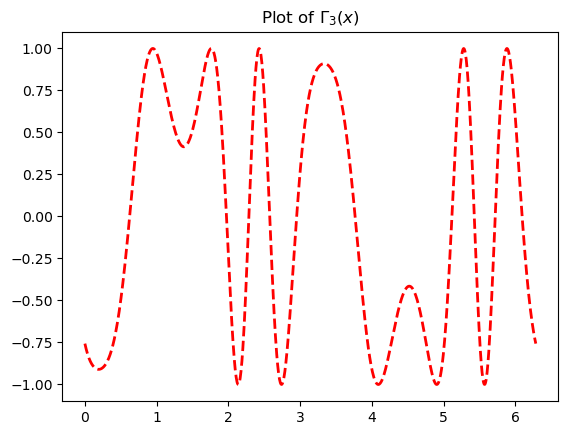

PyObject Text(0.5, 1.0, 'Plot of $\\Gamma_3(x)$')

In [60]:
using PyPlot
x = range(0; stop=2*pi, length=1000);
y = sin.(3 * x + 4 * cos.(2 * x));
plot(x, y, color="red", linewidth=2.0, linestyle="--")
title("A sinusoidally modulated sinusoid")
title(L"Plot of $\Gamma_3(x)$")

In [169]:
function testfunc1(nlist)
    timetake = zeros(length(nlist))
    i = 1
    for n in nlist
        A = randn(n, n)
        b = randn(n)
        tki = 0.0
        for _ in 1:100
            tki += @elapsed A*b
        end
        timetake[i] = tki / 10
        i += 1
    end
    timetake;
end

function testfunc2(nlist)
    timetake = zeros(length(nlist))
    i = 1
    for n in nlist
        a = randn(n)
        b = randn(n)
        tki = 0.0
        for _ in 1:10
            tki += @elapsed a + b
        end
        timetake[i] = tki / 10
        i += 1
    end
    timetake;
end

nlist = [2^i for i in 1:13]
tk1 = testfunc1(nlist);
tk2 = testfunc2(nlist);


(8.238869694029411e-7, -0.002009321827254782)
[-0.0020076740533159763, -0.0020027307314995587, -0.0019895485399891114, -0.001956593061212994, -0.0018774999121503116, -0.0016929492310040527, -0.0012711191026697469, -0.00032200131391755876, 0.0017871493277539703, 0.006427280739431334, 0.016551203819454675, 0.03848637049283858, 0.08573134486628083]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


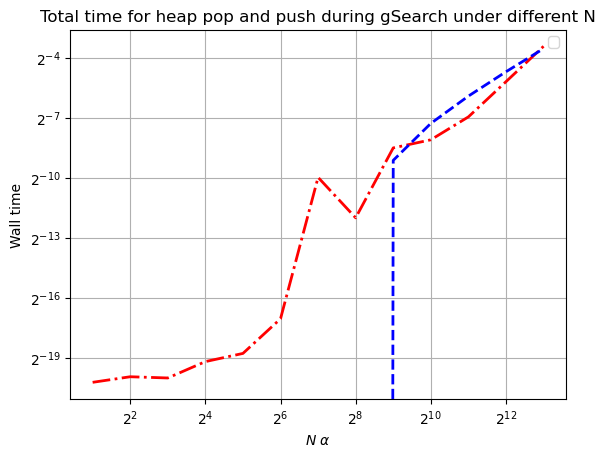

PyObject Text(0.5, 1.0, 'Total time for heap pop and push during gSearch under different N')

In [172]:
figure()
loglog(nlist, tk1, color="red", linewidth=2.0, linestyle="-.", base = 2)
# loglog(nlist, tk2, color="blue", linewidth=2.0, linestyle="--", base = 2)


fst = 1
lst = length(nlist)

ploy1 = fit(nlist[fst:lst].*log2.(nlist[fst:lst]), tk1[fst:lst], 1)
b1, a1 = ploy1.coeffs[1], ploy1.coeffs[2]
println((a1, b1))
ttt = a1.*nlist.*log2.(nlist).+b1
print(ttt)



loglog(nlist, a1.*nlist.*log2.(nlist).+b1, color="blue", linewidth=2.0, linestyle="--", base = 2)

# a*NN*np.log2(NN)+b


xlabel(L"$N$ $\alpha$")
ylabel("Wall time")
grid()
legend()
title("Total time for heap pop and push during gSearch under different N")


(1.2958529000817884e-7, -0.0010159929154125791)
[-0.0007506022414758289, -0.0004188638990548911, 0.0003109604542711722, 0.001903304497891674, 0.005353383259069427, 0.012784322129298434]

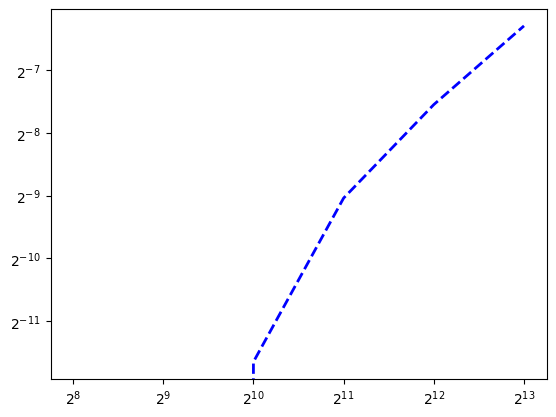

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2e53c6190>

In [159]:
using Polynomials

# # xs = 0:4; ys = @. exp(-xs) + sin(xs);

# # fit(xs, ys,) |> p -> round.(coeffs(p), digits=4) |> Polynomial
# # Polynomial(1.0 + 0.0593*x + 0.3959*x^2 - 0.2846*x^3 + 0.0387*x^4)
# a.coeffs
# # a*NN*np.log2(NN)+b


figure()
# loglog(nlist, tk1, color="red", linewidth=2.0, linestyle="-.", base = 2)
# loglog(nlist, tk2, color="blue", linewidth=2.0, linestyle="--", base = 2)

ploy1 = fit(nlist.*log2.(nlist), tk1, 1)
b1, a1 = ploy1.coeffs[1], ploy1.coeffs[2]
println((a1, b1))
ttt = a1.*nlist.*log2.(nlist).+b1
print(ttt)

# ploy2 = fit(log2.(nlist), log2.(tk1), 1)
# a2, b2 = ploy2.coeffs[1], ploy2.coeffs[2]

# ttt2 = a2.*log2.(nlist).+b2
# print(ttt2)

loglog(nlist, a1.*nlist.*log2.(nlist).+b1, color="blue", linewidth=2.0, linestyle="--", base = 2)


In [ ]:
#     NN = np.array(NN)
#     label1 = ['heap pop', 'heap update', 'heap add new', 'heap push']
#     label2 = {'1': 'test graph 1', '2': 'test graph 2', 'C': 'random complete graph', 'l': 'random line graph', 'O' : 'random graph'}
#     f = 1

#     for i in range(0, 4, 3):
        
#         plt.loglog(NN, t_data[i, :], 'x-', base = 2, label = label1[i]+' of '+label2[GraphUse])
#         a, b = np.polyfit(NN[f:]*np.log2(NN[f:]), t_data[i, f:], 1)
#         plt.loglog(NN, a*NN*np.log2(NN)+b, 'k-.', label = r'LS fit for '+ label1[i]+' of '+label2[GraphUse], base = 2)

# plt.title('Total time for heap pop and push during gSearch under different N')
# plt.xlabel('N')
# plt.ylabel('Wall time')

# plt.grid()
# plt.legend()
# # plt.savefig("Q11_O_LS", dpi=150)
# plt.show()